In [251]:
import matplotlib.pyplot as plt
import json
import re
from collections import Counter
import numpy as np
import matplotlib.cm as cm
import os

In [252]:
path = "C:\\Users\\janst\\OneDrive\\Dokumenty\\Studia\\dypl\\shobuAsWhite" 
#path = "C:\\Users\\janst\\OneDrive\\Dokumenty\\Studia\\dypl\\shobuAsBlack" 
#path = "C:\\Users\\janst\\OneDrive\\Dokumenty\\Studia\\dypl\\both" 

In [253]:
# parse jsons
matches = []
with open(path + "\\tournamentLog.txt", "r") as f:
    log = f.read()
    ms = re.findall(r"\{[\s\S]*?\}", log)
    for m in ms:
        matches.append(json.loads(m))

In [254]:
# prepare stats
count = 0
lengths = []
wins = [0, 0]
timeouts = [0, 0]
errors = [0, 0]
stalemates = 0
draws = 0
for m in matches:
    count += 1
    if m["Stalemate"]:
        stalemates += 1
    elif m["Timeout"]:
        timeouts[m["DisqualifiedPlayer"]] += 1
    elif m["Error"]:
        errors[m["DisqualifiedPlayer"]] += 1
    elif m["EndedSuccessfully"]:
        lengths.append(m["Length"])
        if len(Counter(m["Scores"]).values()) == 1:
            draws += 1
        else:
            for p, s in enumerate(m["Scores"]):
                if s == max(m["Scores"]):
                    wins[p] += 1
    else:
        raise Exception("Match status not set correctly")

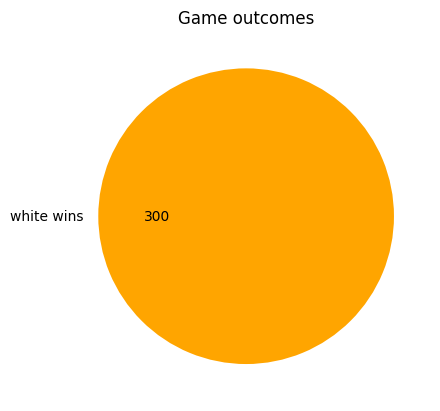

In [255]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{v:d}'.format(v=val)
    return my_format

labels = ["black wins", "white wins", "black timeouts", "white timeouts", "black errors", "white errors", "stalemates", "draws"]
values = [wins[0], wins[1], timeouts[0], timeouts[1], errors[0], errors[1], stalemates, draws]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'grey']  # Define a color for each label

# Filter out labels and values that are zero
non_zero_labels = [label for label, value in zip(labels, values) if value != 0]
non_zero_values = [value for value in values if value != 0]
non_zero_colors = [color for color, value in zip(colors, values) if value != 0]

fig, ax = plt.subplots()
ax.pie(non_zero_values, labels=non_zero_labels, autopct=autopct_format(non_zero_values), colors=non_zero_colors)
plt.title("Game outcomes")
plt.show()

<Figure size 1000x600 with 0 Axes>

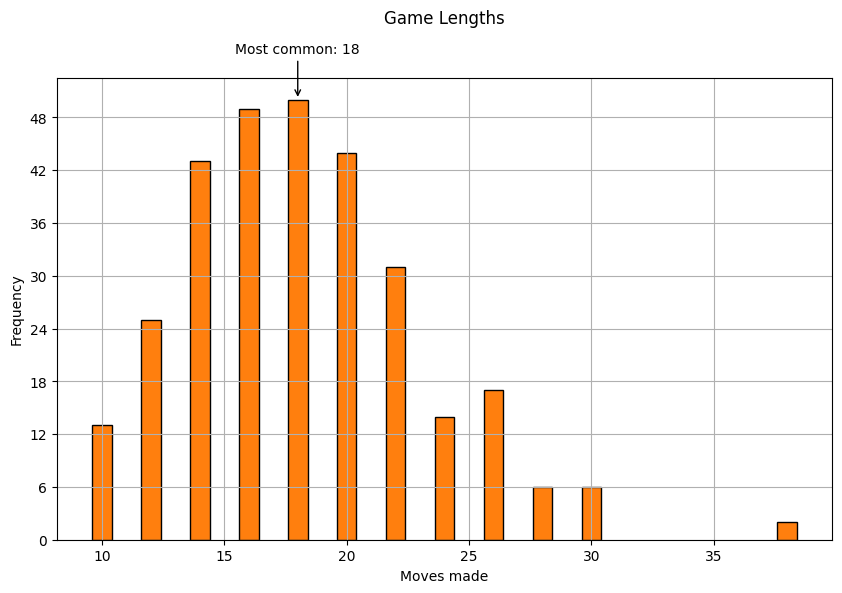

In [256]:
unique_lengths, counts = np.unique(lengths, return_counts=True)

plt.figure(figsize=(10, 6))
cmap = plt.get_cmap('tab10')
colors = [cmap(1) if length % 2 == 0 else cmap(0) for length in unique_lengths]

plt.figure(figsize=(10, 6))
bars = plt.bar(unique_lengths, counts, color=colors, edgecolor='black', width=0.8)
plt.title('Game Lengths', y=1.1)
plt.xlabel('Moves made')
plt.ylabel('Frequency')
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.grid(True, which='major', axis='y')

max_count_index = np.argmax(counts)
plt.annotate(f'Most common: {unique_lengths[max_count_index]}', 
             xy=(unique_lengths[max_count_index], counts[max_count_index]), 
             xytext=(unique_lengths[max_count_index], 1.1 * counts[max_count_index]), 
             ha='center', va='bottom', 
             fontsize=10, color='black', 
             arrowprops=dict(arrowstyle='->'))
plt.show()

In [257]:
# parse all player logs
player_logs = []
for subdir, dirs, fnames in os.walk(path):
    for fname in fnames:
        if not "player" in fname:
            continue
        player_logs.append([])
        fpath = os.path.join(subdir, fname)  
        with open(fpath, "r") as f:
            log = f.read()
            ms = re.findall(r"\{[\s\S]*?\}", log)
            for m in ms:
                player_logs[-1].append(json.loads(m))

In [258]:
# prepare data from player logs
nodes_lists = []
simulation_lists = []
games_count = []
score_lists = []
for logs in player_logs:
    for m, log in enumerate(logs):
        if m == len(games_count):
            nodes_lists.append([log["NumberOfNodes"]])
            score_lists.append([log["MaxAverageScore"]])
            simulation_lists.append([log["RootSimulations"]])
            games_count.append(1)
        else:
            score_lists[m].append(log["MaxAverageScore"])
            nodes_lists[m].append(log["NumberOfNodes"])
            simulation_lists[m].append(log["RootSimulations"])
            games_count[m] += 1
avg_score = [sum(score_lists[i]) / games_count[i] for i in range(len(games_count))]
median_score = [np.median(s) for s in score_lists]
avg_nodes = [sum(nodes_lists[i]) / games_count[i] for i in range(len(games_count))]
medians_nodes = [np.median(n) for n in nodes_lists]
avg_simulations = [sum(simulation_lists[i]) / games_count[i] for i in range(len(games_count))]
medians_simulations = [np.median(s) for s in simulation_lists]

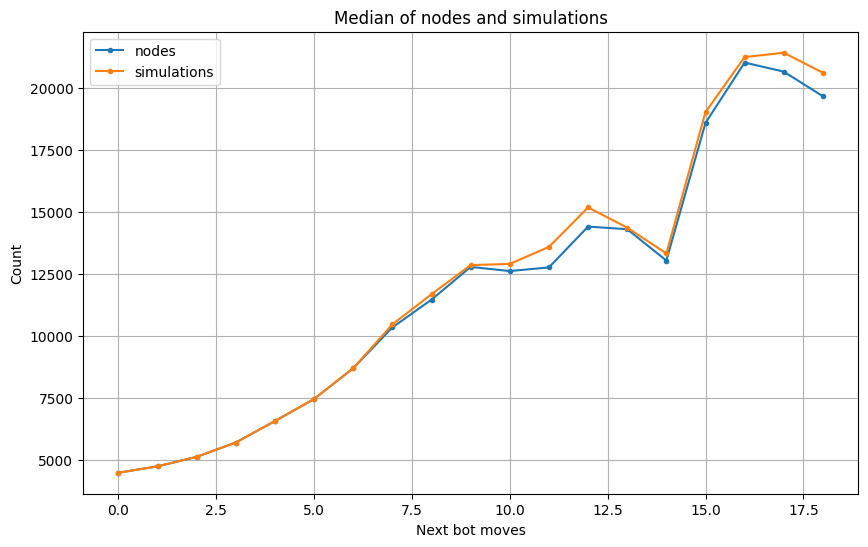

In [259]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(medians_nodes)), medians_nodes, marker='.', label="nodes")
plt.plot(range(len(medians_simulations)), medians_simulations, marker='.', label="simulations")
plt.title('Median of nodes and simulations')
plt.xlabel('Next bot moves')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.show()

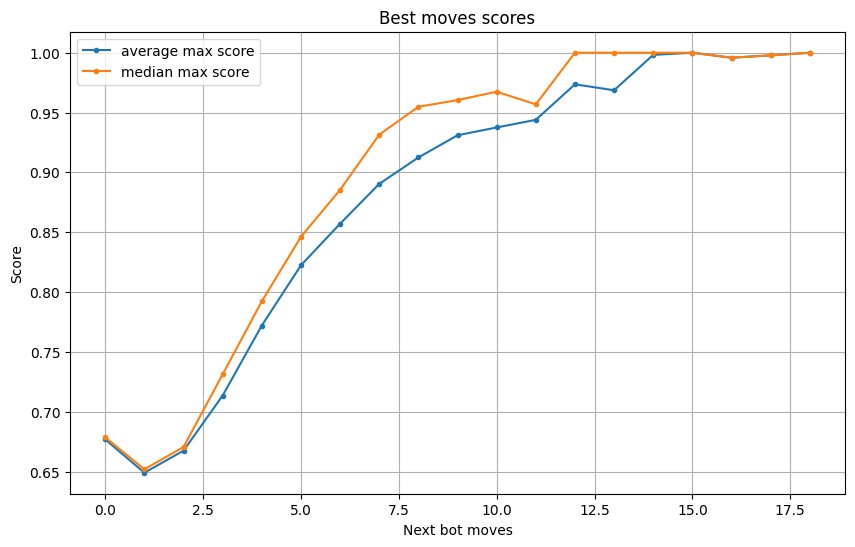

In [260]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(avg_score)), avg_score, marker='.', label="average max score")
plt.plot(range(len(median_score)), median_score, marker='.', label="median max score")
plt.title('Best moves scores')
plt.xlabel('Next bot moves')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()